In [1]:
!pip install --upgrade -q tensorflow tensorflow-io

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.81 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
cudf 23.6.1 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
cuml 23.6.0 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
dask-cudf 23.6.1 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have 

In [3]:
import os
import cv2
import glob
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import multiprocessing
import tensorflow as tf
from pathlib import Path
import concurrent.futures
import keras.backend as K
from time import perf_counter
from functools import lru_cache
import matplotlib.pyplot as plt
from keras import layers, models
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import accuracy_score, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
tf.config.optimizer.set_jit(True)
tf.config.threading.set_inter_op_parallelism_threads(4)
tf.config.threading.set_intra_op_parallelism_threads(4)

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [8]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"

In [9]:
class_names = [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]
image_paths = []
labels = []

for class_name in class_names:
    class_dir = covid_19 / class_name / 'images'
    if os.path.exists(class_dir):
        file_names = [f_name for f_name in os.listdir(class_dir) if f_name.endswith((".jpeg", ".png"))]

        for f_name in tqdm(file_names, desc=f"Processing {class_name}"):
            image_paths.append(os.path.join(class_dir, f_name))
            labels.append(class_name)

Processing COVID: 100%|██████████| 3616/3616 [00:00<00:00, 275455.93it/s]


In [10]:
def is_black_and_white(image):
    """
    Check if the given image is black and white (grayscale).

    Parameters:
        image (PIL.Image.Image): The image object to check.

    Returns:
        bool: True if the image is black and white, False otherwise.
    """
    return image.mode == 'L'

In [11]:
def process_image(image_path, label):
    """
    Process a single image and return the color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if is_black_and_white(image) else 'Colored'
    return label, color_type

def count_images_per_class(image_paths, labels):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(process_image, image_paths, labels), total=len(image_paths), desc="Processing images"))

    for label, color_type in processed_results:
        data[label][color_type] += 1

    df = pd.DataFrame(data).transpose().reset_index()
    df = df.rename(columns={'index': 'Class'})
    return df

result_df = count_images_per_class(image_paths, labels)
print(result_df)

Processing images: 100%|██████████| 21165/21165 [00:24<00:00, 858.24it/s] 

             Class  Black & White  Colored
0           Normal          10192        0
1     Lung_Opacity           6012        0
2  Viral Pneumonia           1205      140
3            COVID           3616        0


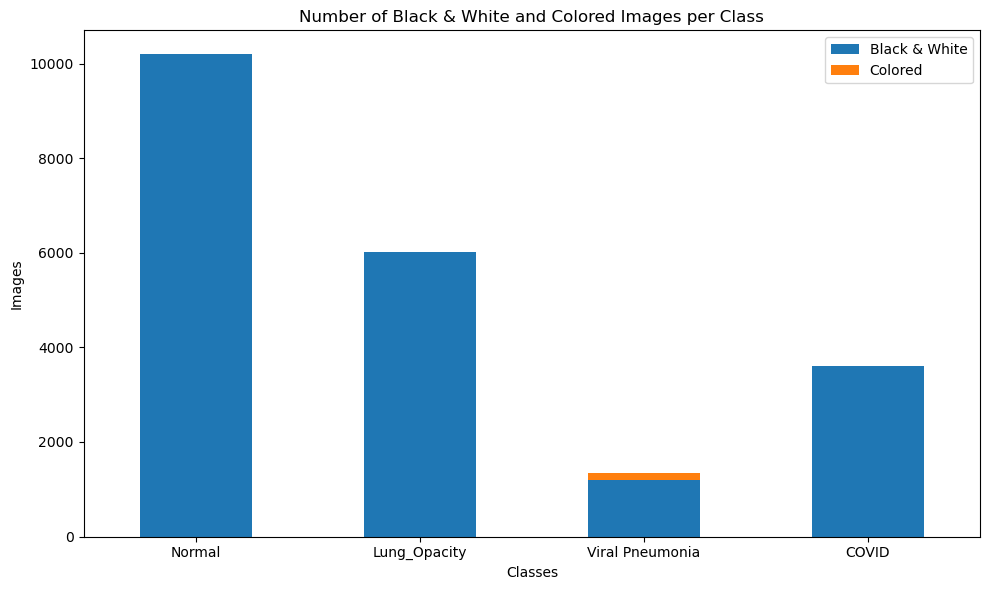

In [12]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    result_df.set_index(class_column, inplace=True)

    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 4/4 [00:00<00:00, 274.42it/s]


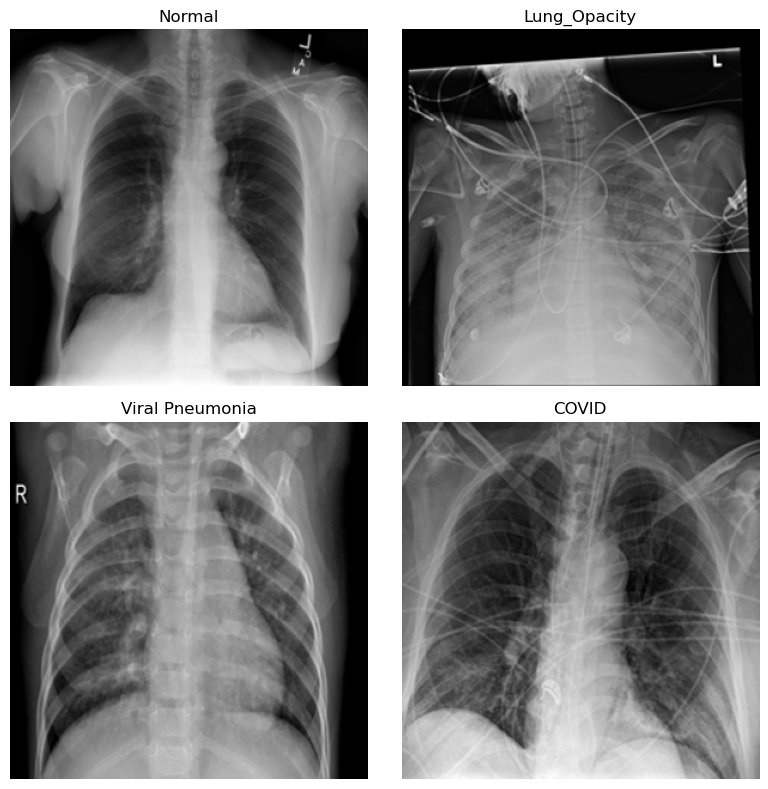

In [13]:
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels):
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    num_rows, num_cols = 1, num_classes
    if num_classes == 4:
        num_rows, num_cols = 2, 2
    elif num_classes == 6:
        num_rows, num_cols = 2, 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                if is_black_and_white(selected_image):
                    ax = axs[i // num_cols, i % num_cols]
                    ax.imshow(selected_image, cmap='gray')
                    ax.set_title(class_label)
                    ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1) 

    plt.tight_layout()
    plt.show()

display_images_per_class(image_paths, labels)

Displaying Images: 100%|██████████| 4/4 [00:13<00:00,  3.29s/it]


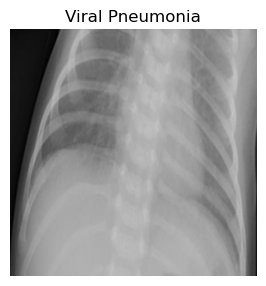

In [14]:
@lru_cache(maxsize=100)
def load_colored_image(image_path):
    """
    Load an image using Pillow and check if it is a colored image (not grayscale).

    Parameters:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray or None: The loaded colored image as a NumPy array, or None if grayscale.
    """
    try:
        img = Image.open(image_path)
        if not is_black_and_white(img):
            return np.array(img)
    except (IOError, OSError) as e:
        raise Exception(f"Error loading image '{image_path}': {e}")
    return None

def display_colored_images(image_paths, labels, num_images_per_class=1):
    """
    Randomly display colored images for each class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        num_images_per_class (int): Number of images to display per class.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    displayed_classes = 0
    unique_labels = set(labels)

    shuffled_labels = list(unique_labels)
    random.shuffle(shuffled_labels)

    for class_label in tqdm(shuffled_labels, desc="Displaying Images"):
        image_paths_for_class = [img_path for img_path, lbl in zip(image_paths, labels) if lbl == class_label]
        colored_images_for_class = [img_path for img_path in image_paths_for_class if load_colored_image(img_path) is not None]

        if len(colored_images_for_class) == 0:
            continue

        num_images_to_display = min(len(colored_images_for_class), num_images_per_class)

        for i in range(num_images_to_display):
            selected_image_path = random.choice(colored_images_for_class)
            selected_image = load_colored_image(selected_image_path)

            displayed_classes += 1
            plt.subplot(2, 3, displayed_classes)
            plt.imshow(selected_image)
            plt.title(f"{class_label}")
            plt.axis('off')

            if displayed_classes == 6:
                break

        if displayed_classes == 6:
            break

    plt.tight_layout()
    plt.show()

display_colored_images(image_paths, labels, num_images_per_class=1)

In [15]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [16]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths,
                                                                      labels_encoded,
                                                                      test_size=0.1,
                                                                      random_state=42,
                                                                      stratify=labels_encoded)

train_paths, test_paths, train_labels, test_labels= train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2222,
                                                                    random_state=42,
                                                                    stratify=train_labels)

In [17]:
train_df = pd.DataFrame({'File Paths': train_paths, 'Labels': train_labels})
val_df = pd.DataFrame({'File Paths': val_paths, 'Labels': val_labels})
test_df = pd.DataFrame({'File Paths': test_paths, 'Labels': test_labels})

total_train_samples = len(train_df)
total_val_samples = len(val_df)
total_test_samples = len(test_df)

train_percentage = (total_train_samples / len(labels_encoded)) * 100
val_percentage = (total_val_samples / len(labels_encoded)) * 100
test_percentage = (total_test_samples / len(labels_encoded)) * 100

train_counts = train_df['Labels'].value_counts().sort_index()
val_counts = val_df['Labels'].value_counts().sort_index()
test_counts = test_df['Labels'].value_counts().sort_index()

train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})

train_df.index = val_df.index = test_df.index = class_names

print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 14815
Total Validation Samples: 2117
Total Test Samples: 4233

Percentage of Split:
Train: 70.00%
Validation: 10.00%
Test: 20.00%

Class Distribution:
                 Train Samples  Validation Samples  Test Samples
Normal                    2531                 362           723
Lung_Opacity              4209                 601          1202
Viral Pneumonia           7134                1019          2039
COVID                      941                 135           269


In [18]:
def image_generator(img_paths, img_labels, batch_size):
    """Generator function to load and preprocess images in batches.

    Args:
        img_paths (list): List of image file paths.
        img_labels (list): List of corresponding image labels.
        batch_size (int): Size of the batch.

    Yields:
        tuple: A tuple containing the batch of images and their corresponding labels.
    """
    num_samples = len(img_paths)

    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = img_paths[offset:offset + batch_size]
            batch_labels = img_labels[offset:offset + batch_size]

            batch_images = []
            for img_path in batch_paths:
                image = cv2.imread(str(img_path))
                resized_image = cv2.resize(image, (224, 224))
                normalized_image = resized_image / 255.0
                batch_images.append(normalized_image)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes)

In [19]:
BATCH_SIZE = 16

train_generator = image_generator(train_paths, train_labels, BATCH_SIZE)
train_steps = len(train_paths) // BATCH_SIZE

val_generator = image_generator(val_paths, val_labels, BATCH_SIZE)
val_steps = len(val_paths) // BATCH_SIZE

test_generator = image_generator(test_paths, test_labels, BATCH_SIZE)
test_steps = len(test_paths) // BATCH_SIZE

In [20]:
inputs = layers.Input(shape=(224, 224, 3), name="Input")

# Block 1
x = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv1")(inputs)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv1")(x)
x = layers.BatchNormalization()(x)
blk1 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool1")(x)

# Block 2
x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", name="Conv2")(blk1)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv2")(x)
x = layers.BatchNormalization()(x)
blk2 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool2")(x)

# Block 3
x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv3")(blk2)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same", name="MaxPool3")(x)
x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv4")(x)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv3")(x)
x = layers.BatchNormalization()(x)
blk3 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool4")(x)

# Block 4
x = layers.Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu", name="Conv5")(blk3)
x = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool5")(x)
x = layers.Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu", name="Conv6")(x)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv4")(x)
blk4 = layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling2D(name="GAP")(x)

outputs = layers.Dense(num_classes, activation="softmax", name="Output")(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

num_layers = len(model.layers)
print("\nNumber of layers in the model:", num_layers)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 DConv1 (DepthwiseConv2D)    (None, 224, 224, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 112, 112, 64)      0         
                                                                 
 Conv2 (Conv2D)              (None, 112, 112, 64)      36928     
                                                             

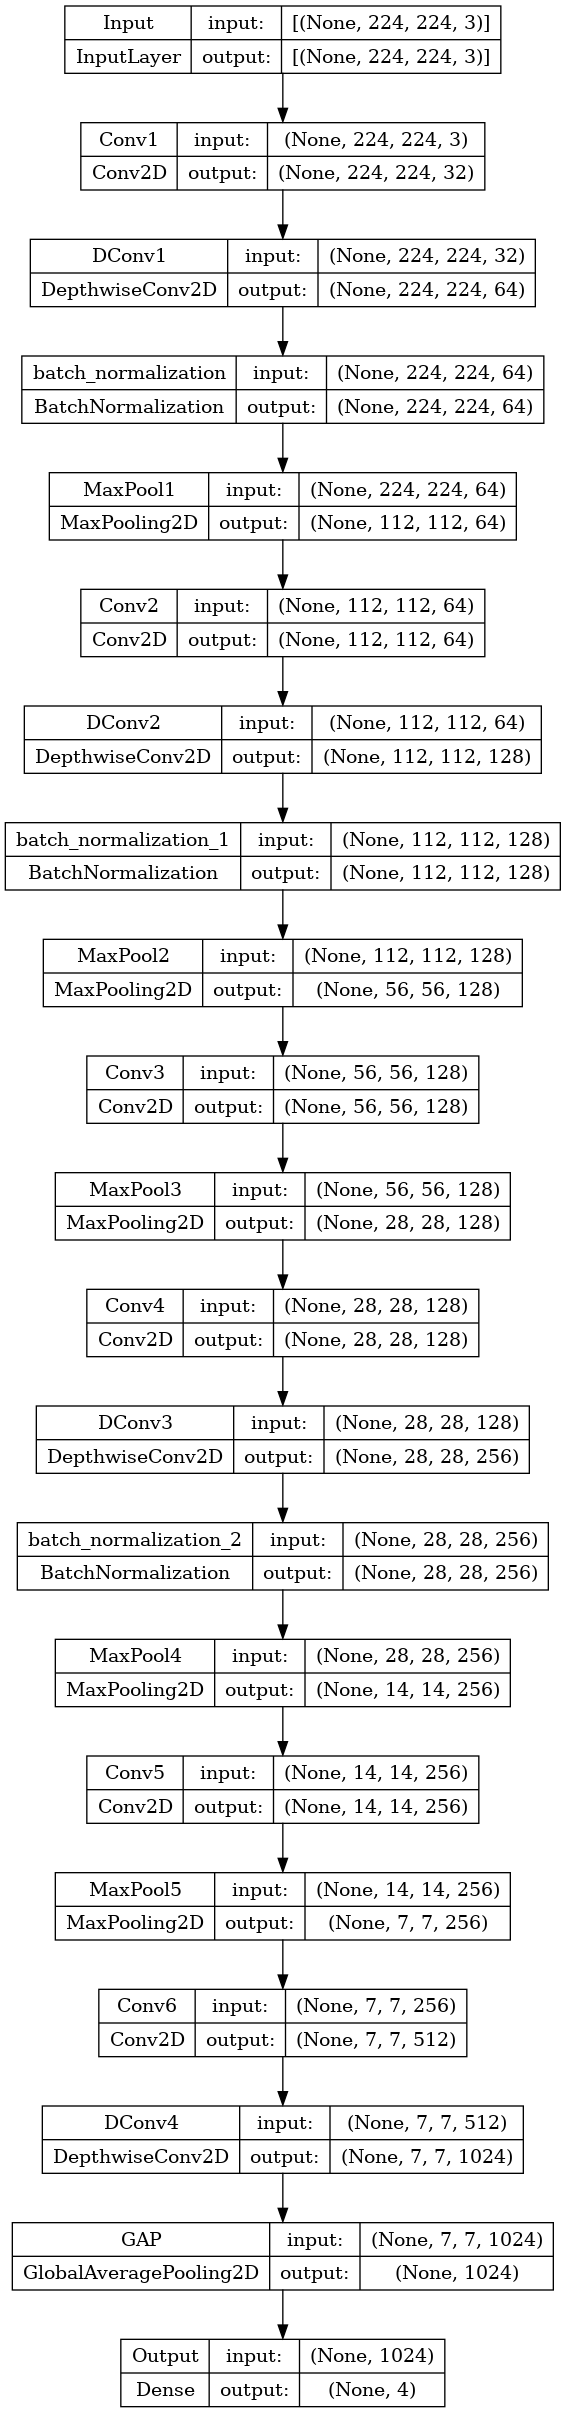

In [21]:
plot_model(model, show_shapes=True)

In [22]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, sensitivity, specificity, mcc, auc).
    """
    
    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric
    )

In [23]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', create_metrics()]
)

In [24]:
TOTAL_EPOCHS = 25
INITIAL_LEARNING_RATE = 0.75e-4
DECAY_RATE = 0.96

def learning_rate_scheduler(epoch, current_learning_rate):
    """
    A function that returns the learning rate for each epoch.

    Args:
        epoch (int): The current epoch.
        current_learning_rate (float): The current learning rate.

    Returns:
        float: The new learning rate.
    """
    if epoch < (TOTAL_EPOCHS / 3):
        new_learning_rate = INITIAL_LEARNING_RATE
    else:
        new_learning_rate = current_learning_rate * DECAY_RATE

    return new_learning_rate

In [25]:
learning_rate_callback = LearningRateScheduler(learning_rate_scheduler)

In [26]:
start_time = perf_counter()
history = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=train_steps,
    callbacks=[learning_rate_callback],
    validation_data=val_generator,
    validation_steps=val_steps
)
end_time = perf_counter()

Epoch 1/25
925/925 [==============================] - 101s 82ms/step - loss: 0.7385 - accuracy: 0.7042 - precision: 0.7833 - recall: 0.6122 - f1_score: 0.6706 - specificity: 0.9435 - sensitivity: 0.6122 - mcc: 0.5971 - auc: 0.9060 - val_loss: 0.8982 - val_accuracy: 0.6548 - val_precision: 0.6922 - val_recall: 0.6080 - val_f1_score: 0.6456 - val_specificity: 0.9099 - val_sensitivity: 0.6080 - val_mcc: 0.5413 - val_auc: 0.8740 - lr: 7.5000e-05
Epoch 2/25
925/925 [==============================] - 75s 79ms/step - loss: 0.4016 - accuracy: 0.8553 - precision: 0.8717 - recall: 0.8381 - f1_score: 0.8540 - specificity: 0.9589 - sensitivity: 0.8381 - mcc: 0.8076 - auc: 0.9706 - val_loss: 0.8318 - val_accuracy: 0.6954 - val_precision: 0.7215 - val_recall: 0.6697 - val_f1_score: 0.6937 - val_specificity: 0.9140 - val_sensitivity: 0.6693 - val_mcc: 0.5987 - val_auc: 0.9007 - lr: 7.5000e-05
Epoch 3/25
925/925 [==============================] - 85s 92ms/step - loss: 0.2946 - accuracy: 0.8967 - preci

In [27]:
execution_time = end_time - start_time

milliseconds = int(execution_time * 1000)
seconds, milliseconds = divmod(milliseconds, 1000)
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

time_string = f"{hours} hours, " if hours else ""
time_string += f"{minutes} minutes, " if minutes else ""
time_string += f"{seconds} seconds, " if seconds else ""
time_string += f"{milliseconds} milliseconds"

print(f"Model training took {time_string}")

Model training took 29 minutes, 40 seconds, 595 milliseconds


In [28]:
_ = model.evaluate(test_generator, steps=test_steps)

264/264 [==============================] - 19s 74ms/step - loss: 0.3687 - accuracy: 0.9318 - precision: 0.9327 - recall: 0.9316 - f1_score: 0.9321 - specificity: 0.9776 - sensitivity: 0.9316 - mcc: 0.9095 - auc: 0.9790


In [35]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.set_xlabel("Epochs")
        ax.legend()

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

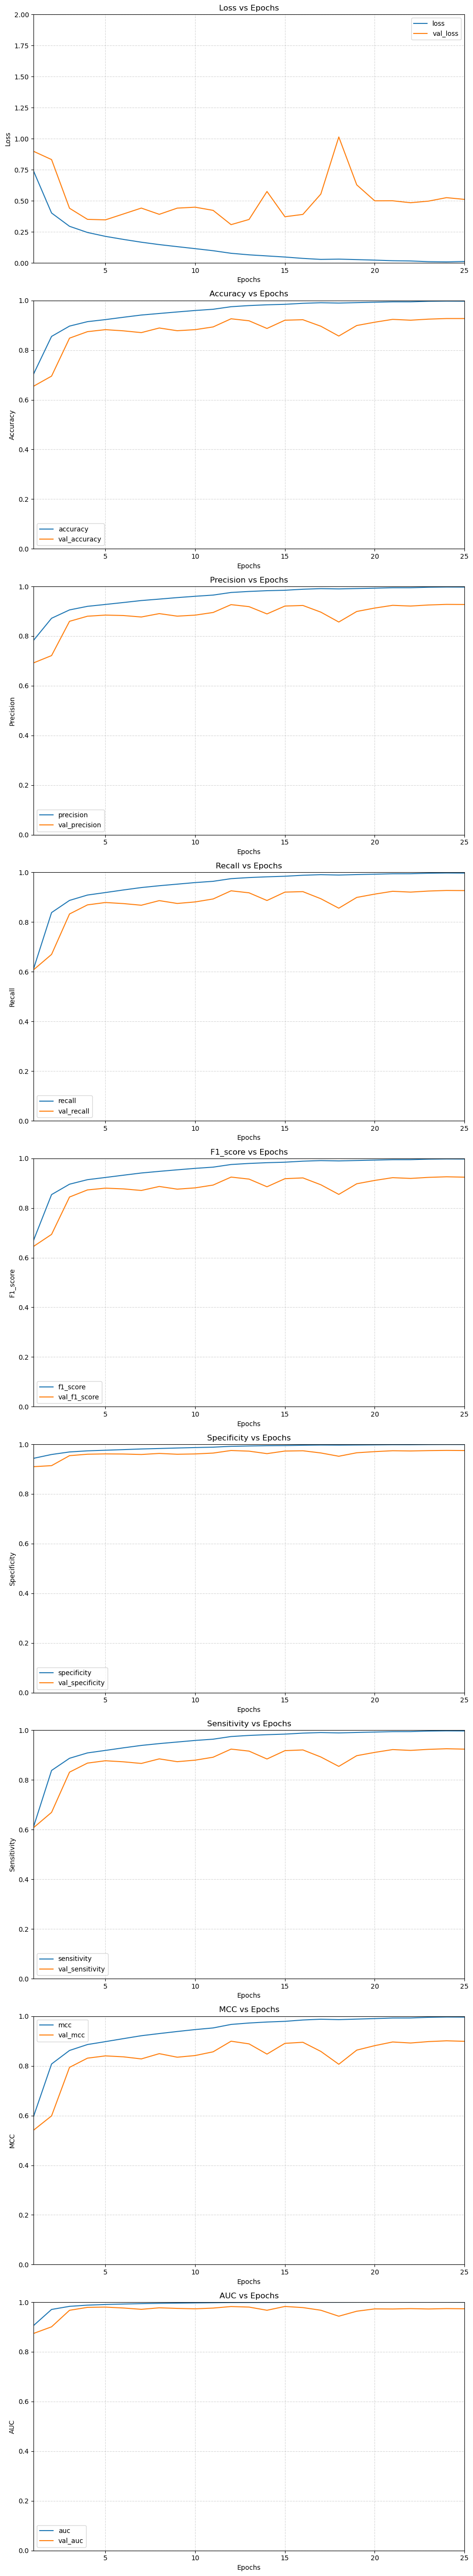

In [36]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
plot_metrics(history, metric_names)

In [31]:
def generate_classification_report(model, test_generator, test_steps, batch_size, target_names):
    """
    Generate a classification report, accuracy, and number of errors for a given model and test generator.

    Args:
        model (object): The trained model.
        test_generator (object): The test data generator.
        test_steps (int): The number of steps to iterate over the test generator.
        batch_size (int): The batch size for generating predictions.
        target_names (list): List of target class names for the classification report.

    Returns:
        tuple: A tuple containing true labels, predicted labels, and the classification report.
    """
    predicted_labels = []
    true_labels = []

    for i in range(test_steps):
        batch_data, batch_true_labels = next(test_generator)

        batch_predicted_labels = model.predict_on_batch(batch_data)
        batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)

        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(batch_true_labels)

    true_labels = np.array(true_labels)

    if len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    report = classification_report(
        true_labels,
        predicted_labels,
        target_names=target_names,
        digits=4,
        zero_division=1
    )

    accuracy = accuracy_score(true_labels, predicted_labels)
    num_errors = np.sum(true_labels != predicted_labels)

    print(report)
    print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

    return true_labels, predicted_labels

In [32]:
true_labels, predicted_labels = generate_classification_report(
    model, test_generator, test_steps, BATCH_SIZE, classes
)

                 precision    recall  f1-score   support

          COVID     0.9616    0.9736    0.9676       721
   Lung_Opacity     0.9307    0.8507    0.8889      1199
         Normal     0.9144    0.9661    0.9395      2035
Viral Pneumonia     1.0000    0.9219    0.9594       269

       accuracy                         0.9318      4224
      macro avg     0.9517    0.9281    0.9389      4224
   weighted avg     0.9325    0.9318    0.9312      4224

There were 288 errors in 4224 tests for an accuracy of  93.18


In [33]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    """
    Compute the confusion matrix.

    Args:
        true_labels (list or numpy.ndarray): Array-like object of true labels.
        predicted_labels (list or numpy.ndarray): Array-like object of predicted labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

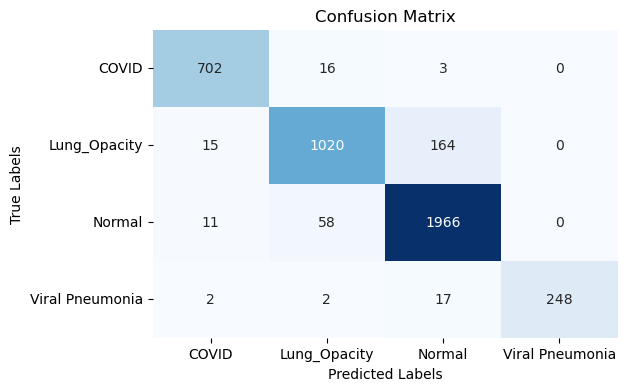

In [34]:
cm = confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()